In [0]:
'''
Model Analysis - Clustering
'''
import os
import pickle
import re
import nltk
nltk.download('punkt')
import heapq
import numpy as np
from random import shuffle
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
####################################
# LOAD Model output
####################################
with open('/content/drive/My Drive/CS 263 Project/BoW_info_full.pickle','rb') as f:
    BoW = pickle.load(f)
with open('/content/drive/My Drive/CS 263 Project/bert_similarities.p','rb') as f:
    BERT = pickle.load(f)
with open('/content/drive/My Drive/CS 263 Project/doc2vec_similarity.pickle','rb') as f:
    D2V = pickle.load(f)
with open('/content/drive/My Drive/CS 263 Project/BiLSTM_similarity.pickle','rb') as f:
    LSTM = pickle.load(f)

#Embeddings 
BoW_Embeddings = BoW["BoW"]["embedding"]
BERT_Embeddings = BERT['embeddings']
D2V_Embeddings = D2V[0]
LSTM_Embeddings = LSTM[0]

#IDs
BoW_IDs = BoW["BoW"]["ids"]
BERT_IDs = BERT['ids']
D2V_IDs = D2V[1]
LSTM_IDs = LSTM[1]

In [0]:
####################################
# LOAD FULL BAKING DATA
####################################
#Lang Class
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

#get data
with open('/content/drive/My Drive/CS 263 Project/baking_data_title_ingredients.pickle','rb') as f:
    baking_data = pickle.load(f)

with open('/content/drive/My Drive/CS 263 Project/nutritional_info.pickle','rb') as f:
    nutritional_df = pickle.load(f)

# Index out
health_mask = baking_data[0].id.isin(nutritional_df.id)

# baking dataframe
df = baking_data[0][health_mask] #5000 obs
list(df.columns)

#nutrition df
list(nutritional_df.columns)

# Recipe IDs
baking_ids = df.id.values
baking_strings = np.array(baking_data[1])[health_mask].tolist()

# list of strings representing each recipe (instructions only)
# Remove Separaters
baking_strings = [item.replace('--|||--', '').replace('||', '') for item in np.array(baking_data[1])[health_mask].tolist()]
# Remove extra white space
baking_strings = [" ".join(item.split()) for item in baking_strings]  
            
baking_ids_with_strings = list(zip(baking_strings, baking_ids))

baking_sent = [instructions[0] for instructions in baking_ids_with_strings]
ids_limited= [id[1] for id in baking_ids_with_strings]

In [0]:
#######################################################
## PCA & K-Means Clustering Functions
#######################################################  
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

#PCA on embeddings function
def PCA_funk(embdeddings,nPCs=5): 
  pca = PCA(n_components=nPCs).fit(embdeddings)
  return(pca.transform(embdeddings),pca.explained_variance_ratio_)

#K-Means clustering on embeddings function
def KM_Funk(embeddings,nclus=10):
  km = KMeans(n_clusters=nclus)
  km.fit(embeddings)
  return(km.labels_.tolist())

In [0]:
#######################################################
## K-Means PCA Plot Functions
####################################################### 

#K-Means PCA Plot Function
def KM_PCA_PlotFunk(embeddings,clusters,title,nclus=10,nPCs=5):
  #run PCA on embeddings
  pca_trans,var_exp = PCA_funk(embeddings,nPCs)
  #plot variance explained by PCs
  plt.bar(range(len(var_exp)), var_exp, color='black')
  plt.title('PC Variance Explained for '+title)
  plt.ylabel('Variance Explained')
  plt.xlabel('Principle Component')
  plt.show()
  #plot PC1 vs PC2 colored by K-means clustering
  scatter = plt.scatter(pca_trans[:,0], pca_trans[:,1], c=clusters,alpha=0.1)
  #plt.legend(*scatter.legend_elements(num=nclus),loc="upper left", title="Cluster")
  plt.title('K-Means Clustering for '+title)
  plt.ylabel('Principle Component 2')
  plt.xlabel('Principle Component 1')
  if np.max(pca_trans[:,0])>500:
    plt.xlim(-500,500)
  plt.show()

In [0]:
#######################################################
## Most common words in clusters Functions
#######################################################  

#ClusterWords Function
def ClusterWords(clusters,title,num_clusters):

  print("###########################")
  print(title)
  print("###########################")

  #create cluster & recipe dataframe
  cluster_data = { 'recipe': ids_limited, 'cluster': clusters}
  frame = pd.DataFrame(cluster_data, index = [clusters] , columns = ['recipe', 'cluster'])
  frame['string'] = baking_strings
  frame['cluster'].value_counts()

  #print first 10 recipes in each cluster
  for i in range(num_clusters):
      recipe_ids = frame.recipe[i]
      print("Cluster %d Recipes:" % i)
      print(df[df.id.isin(recipe_ids)].title.values[0:10])

  ## Find keyword ingredients
  # CLUSTER 0
  wordfreq_cluster0 = {} 
  cluster0_mask = frame['cluster']==0
  cluster0_df = frame[cluster0_mask]
  cluster0_baking_sent = cluster0_df['string'].tolist()
  for sentence in cluster0_baking_sent:
      tokens = nltk.word_tokenize(sentence)
      for token in tokens:
          if token not in wordfreq_cluster0.keys():
              wordfreq_cluster0[token] = 1
          else:
              wordfreq_cluster0[token] += 1
  most_freq_cluster0 = heapq.nlargest(100, wordfreq_cluster0, key=wordfreq_cluster0.get)            
  print(most_freq_cluster0)  

  # CLUSTER 1
  wordfreq_cluster1 = {} 
  cluster1_mask = frame['cluster']==1
  cluster1_df = frame[cluster1_mask]
  cluster1_baking_sent = cluster1_df['string'].tolist()
  for sentence in cluster1_baking_sent:
      tokens = nltk.word_tokenize(sentence)
      for token in tokens:
          if token not in wordfreq_cluster1.keys():
              wordfreq_cluster1[token] = 1
          else:
              wordfreq_cluster1[token] += 1
  most_freq_cluster1 = heapq.nlargest(100, wordfreq_cluster1, key=wordfreq_cluster1.get)                    
  print(most_freq_cluster1)

  #find unique words in each cluster
  unique0 = set(most_freq_cluster0) - set(most_freq_cluster1)
  print(unique0)
  unique1 = set(most_freq_cluster1) - set(most_freq_cluster0)
  print(unique1)

In [0]:
#######################################################
## Run Cluster Analyses 
#######################################################  

#set number of clusters and PCs
num_pcs = 5
num_clusters=2

In [0]:
#Get Clusters
D2V_Clusters = KM_Funk(D2V_Embeddings,nclus=num_clusters)
BERT_Clusters = KM_Funk(BERT_Embeddings,nclus=num_clusters)
LSTM_Clusters = KM_Funk(LSTM_Embeddings,nclus=num_clusters)
BoW_Clusters = KM_Funk(BoW_Embeddings,nclus=num_clusters)

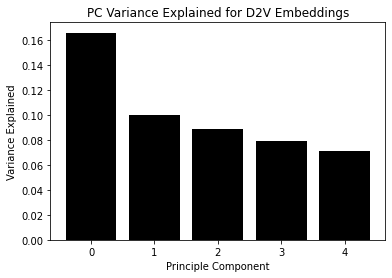

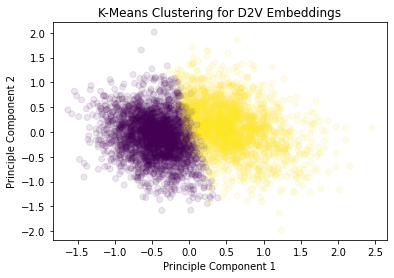

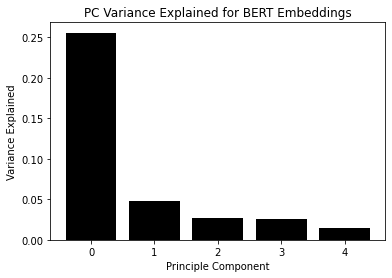

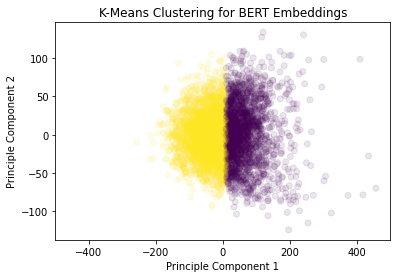

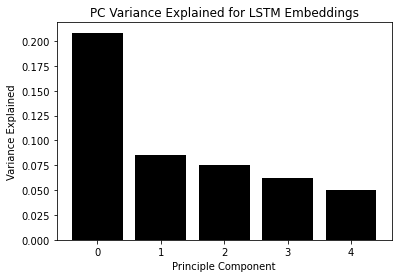

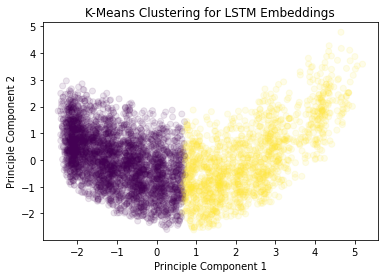

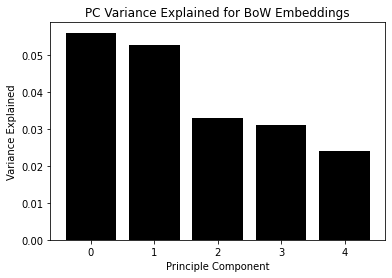

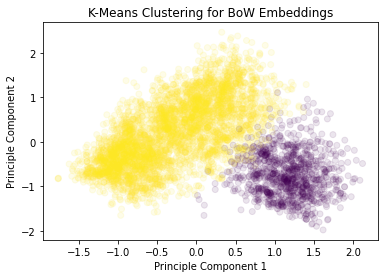

In [0]:
#Cluster PCA Plots
KM_PCA_PlotFunk(D2V_Embeddings,D2V_Clusters,"D2V Embeddings",nclus=num_clusters,nPCs=num_pcs)
KM_PCA_PlotFunk(BERT_Embeddings,BERT_Clusters,"BERT Embeddings",nclus=num_clusters,nPCs=num_pcs)
KM_PCA_PlotFunk(LSTM_Embeddings,LSTM_Clusters,"LSTM Embeddings",nclus=num_clusters,nPCs=num_pcs)
KM_PCA_PlotFunk(BoW_Embeddings,BoW_Clusters,"BoW Embeddings",nclus=num_clusters,nPCs=num_pcs)

In [0]:
#ClusterWords
ClusterWords(D2V_Clusters,"D2V",num_clusters)
ClusterWords(BERT_Clusters,"BERT",num_clusters)
ClusterWords(LSTM_Clusters,"LSTM",num_clusters)
ClusterWords(BoW_Clusters,"BoW",num_clusters)

###########################
D2V
###########################
Cluster 0 Recipes:
['Sugar Free Pudge-less Brownies' 'Barbeque Brisket Rub' 'Pitas'
 'Corn Cake Casserole' 'Four Hour Baguettes' 'Focaccia Buns'
 'Easy Pizza Dough for Bread Machine' 'Spicy Pepitas' 'Greatest Granola'
 'Luscious Luau']
Cluster 1 Recipes:
["Aunt Julie's Pineapple Cookies" 'White Chocolate Bark'
 'Baked Brown Rice' 'Five-Spice Tofu Stir-Fry with Carrots and Celery'
 'Decadent Vegan Dark- Choco Brownies' 'Crunchy Granola' 'Apricot Strudel'
 'Advent Cookies' 'Cheese Buttons' 'Simple Potato Bread']
['flour', 'salt', 'sugar', 'bread', 'water', 'yeast', 'butter', 'dri', 'oil', 'honey', '-', 'wheat', 'powder', 'bake', 'whole', 'milk', 'brown', 'seed', 'purpos', 'oliv', 'ground', 'oat', 'syrup', 'pepper', 'chees', 'cinnamon', 'warm', 'white', 'activ', 'soda', 'chicken', 'almond', 'garlic', 'mapl', 'roll', 'fresh', 'potato', 'vanilla', 'unsalt', 'sauc', 'onion', 'veget', 'extract', 'coconut', 'granola', 'chocol', 'pizza